The dataset is taken from: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data

Prediction of whether there are exoplanets near star by changing light intensity. Perceptron is used as model for prediction

### Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns; sns.set()

from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import normalize, StandardScaler
from sklearn import linear_model
from imblearn.over_sampling import SMOTE
from scipy import ndimage, fft

%matplotlib inline

#see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Load data set

In [2]:
train_df = pd.read_csv('../input/exoTrain.csv')
test_df = pd.read_csv('../input/exoTest.csv')

Data format observation

In [3]:
train_df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Shape of data matrix and label counts

In [4]:
print(train_df.shape)

(5087, 3198)


In [5]:
train_df.LABEL.value_counts(normalize=True)

1    0.992727
2    0.007273
Name: LABEL, dtype: float64

In [6]:
test_df.LABEL.value_counts(normalize=True)

1    0.991228
2    0.008772
Name: LABEL, dtype: float64

In [7]:
X_train = train_df.loc[:, train_df.columns != 'LABEL'].values
y_train = train_df.LABEL.values

X_test = test_df.loc[:, train_df.columns != 'LABEL'].values
y_test = test_df.LABEL.values

### Visualization of time series

In [8]:
def get_distribution_params(intensity_vals, window_size=10):
    """Returns rolling meand and rolling standard deviation by given time series and window size"""
    return intensity_vals.rolling(window_size).mean(), intensity_vals.rolling(window_size).std()

def plot_light_intensity(X, figsize=(16,8), resolution=1.0):
    """Plots given light intensity time series"""
    
    if resolution < 1.0:
        resolution = int(1.0//resolution)
        X = X[::resolution]
    
    intensity_vals = pd.DataFrame(X)
    measurements = [i for i in range(1, len(X) + 1, 1)]
    
    rolling_mean_variety, rolling_std_variety = get_distribution_params(intensity_vals)
    
    plt.figure(figsize=(figsize[0],figsize[1]))
    plt.title = "Start light intensity variation"
     
    plt.plot(measurements, intensity_vals.values,color='b')
    plt.plot(measurements, rolling_mean_variety.values,color='r')
    plt.plot(measurements, rolling_std_variety.values,color='g')

    blue_line = mlines.Line2D([], [], color='blue', label='Light intensity meterages')
    red_line = mlines.Line2D([], [], color='red', label='Mean light intensity')
    green_line = mlines.Line2D([], [], color='green', label='Standard deviation of light intensity')
    plt.legend(handles=[blue_line, red_line, green_line])

    plt.xlabel('Meterages', fontsize=18)
    
    plt.xticks(rotation=90)
    plt.ylabel('Light intensity', fontsize=18)

    plt.show()

Visualization of series for first star having expoplanets

Number of plotted series:  0


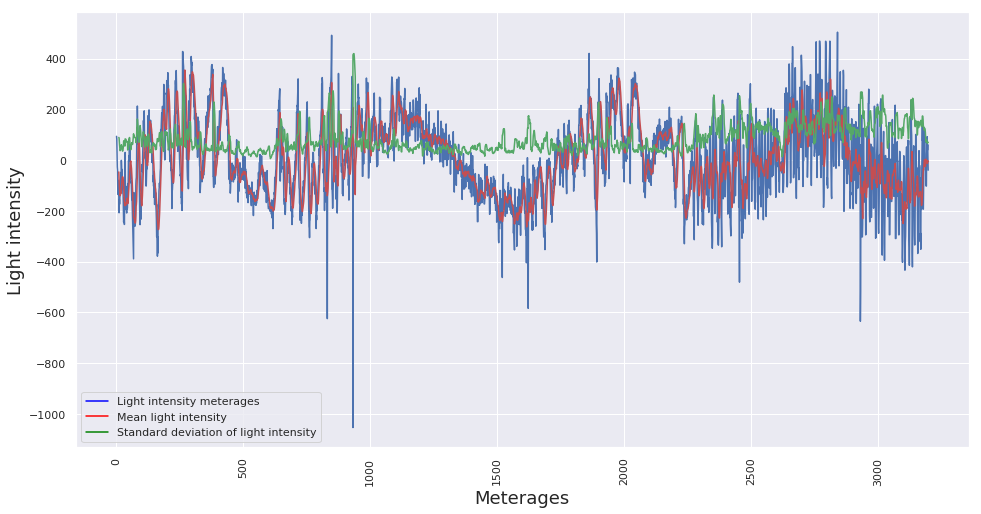

In [9]:
series_number = list(y_train).index(2)
print("Number of plotted series: ", series_number)

plot_light_intensity(X_train[series_number], resolution=1.0)

Decomposition into seasonal, trend, residual and fourier transform components

In [10]:
def seasonal_decompose_fft(X, freq):
    """Returns decomposed time series into seasonal, trend, residual, observed
    and fourier transform components"""
    decomposition = seasonal_decompose(X, freq=freq)
    
    return DecomposeResult(seasonal=decomposition.seasonal, trend=decomposition.trend,
                           resid=decomposition.resid, observed=decomposition.observed, 
                           fft=np.fft.fft(decomposition.seasonal))

def plot_decomposed_seasonal(decomposition):
    """Plots decomposition of seasonal_decompose_fft function"""
    plt.figure(figsize=(16,8))
    plt.subplot(511)
    plt.plot(decomposition.observed, label='Original')
    plt.legend(loc='best')
    plt.subplot(512)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(513)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(514)
    plt.plot(decomposition.resid, label='Residuals')
    plt.legend(loc='best')
    if hasattr(decomposition, 'fft'):
        plt.subplot(515)
        plt.plot(decomposition.fft, label='Fourier decomposition')
        plt.legend(loc='best')
    plt.tight_layout()

/home/artem/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


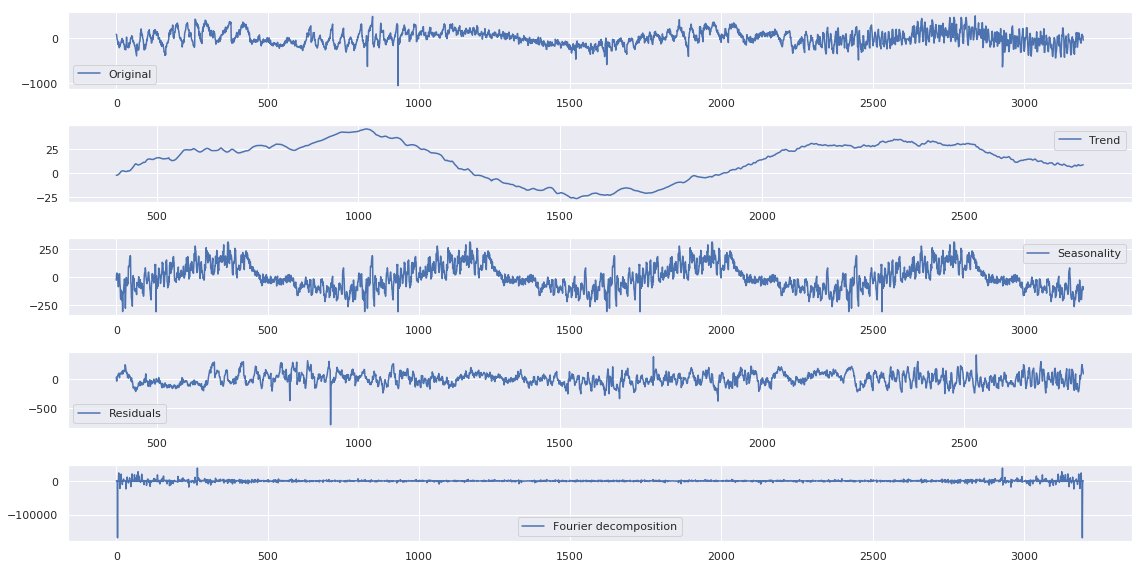

In [11]:
decomposition = seasonal_decompose_fft(X_train[series_number], freq=800)
plot_decomposed_seasonal(decomposition)

### Data processing for model training

In [12]:
X_dec = [seasonal_decompose_fft(X_train[i], freq=800) for i in range(0, len(X_train), 1)]
X_test_dec = [seasonal_decompose_fft(X_test[i], freq=800) for i in range(0, len(X_test), 1)]

No need to have full data - abolute values of half of every series is enough to be unique

In [13]:
X_fft = absolute = [np.abs(X.fft[:(len(X.fft)//2)]) for X in X_dec]
X_test_fft = [np.abs(X.fft[:(len(X.fft)//2)]) for X in X_test_dec]

Normalyzing to same scale every series

In [14]:
X_fft = normalized = normalize(X_fft)
X_test_fft = normalize(X_test_fft)

Applying of gaussian filter

In [15]:
X_fft = filtered = ndimage.filters.gaussian_filter(X_fft, sigma=10)
X_test_fft = ndimage.filters.gaussian_filter(X_test_fft, sigma=10)

Scaling variances

In [16]:
std_scaler = StandardScaler()
X_fft = scaled = std_scaler.fit_transform(X_fft)
X_test_fft = std_scaler.fit_transform(X_test_fft)

Plotting data changes

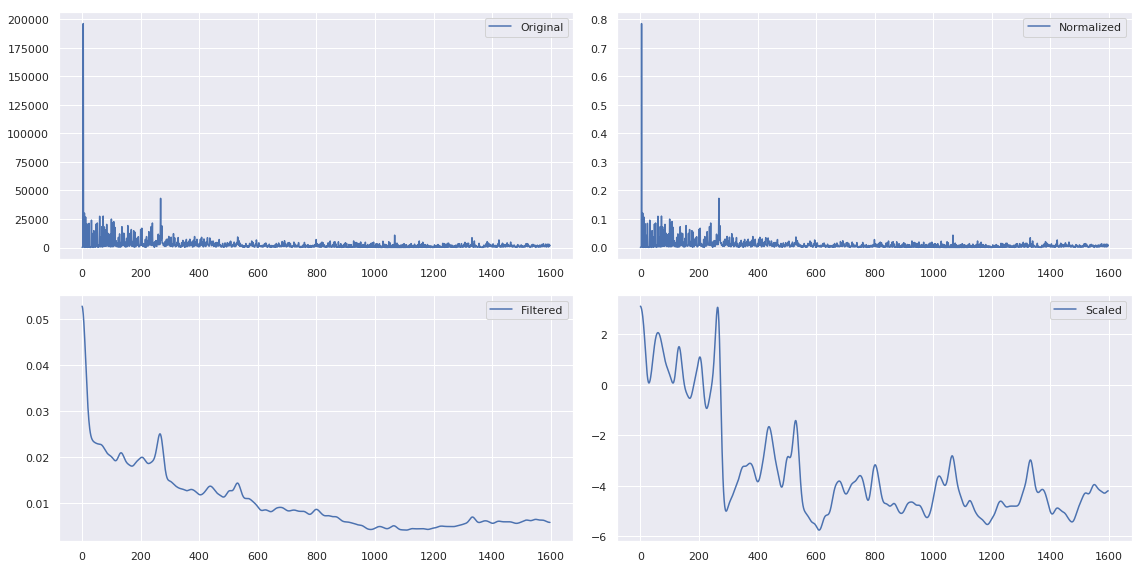

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(221)
plt.plot(absolute[series_number], label='Original')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(normalized[series_number], label='Normalized')
plt.legend(loc='best')
plt.subplot(223)
plt.plot(filtered[series_number],label='Filtered')
plt.legend(loc='best')
plt.subplot(224)
plt.plot(scaled[series_number],label='Scaled')
plt.legend(loc='best')
plt.tight_layout()

As training sample is very imbalanced it's necessary to over-sample by creating some non-existing expoplanet systems

In [18]:
sm = SMOTE(ratio = 1.0)
X_fft_sm, y_train_sm = sm.fit_sample(X_fft, y_train)

print(len(X_fft_sm))

/home/artem/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


10100


### Model training and prediction

In [19]:
model = linear_model.SGDClassifier(max_iter=1000, loss="perceptron", penalty="l2", alpha=1e-2, eta0=1.0, learning_rate="invscaling")
model.fit(X_fft_sm, y_train_sm)

SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=1.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='invscaling', loss='perceptron',
       max_iter=1000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       tol=None, validation_fraction=0.1, verbose=0, warm_start=False)

In [20]:
Y_train_predicted = model.predict(X_fft_sm)
Y_test_predicted =  model.predict(X_test_fft)

print("Train accuracy = %.4f" % accuracy_score(y_train_sm, Y_train_predicted))
print("Test accuracy = %.4f" % accuracy_score(y_test, Y_test_predicted))

Train accuracy = 1.0000
Test accuracy = 0.9982


Display labels of start from test sample together with predicted to see difference

In [21]:
print(y_test)
print(Y_test_predicted)

[2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

### Report

In [22]:
confusion_matrix_train = confusion_matrix(y_train_sm, Y_train_predicted)
confusion_matrix_test = confusion_matrix(y_test, Y_test_predicted)
classification_report_train = classification_report(y_train_sm, Y_train_predicted)
classification_report_test = classification_report(y_test, Y_test_predicted)

print("Confusion Matrix (train sample):\n", confusion_matrix_train)
print("Confusion Matrix (test sample):\n", confusion_matrix_test)
print("\n")
print("Classification_report (train sample):\n", classification_report_train)
print("Classification_report (test sample):\n", classification_report_test)

Confusion Matrix (train sample):
 [[5050    0]
 [   0 5050]]
Confusion Matrix (test sample):
 [[564   1]
 [  0   5]]


Classification_report (train sample):
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      5050
           2       1.00      1.00      1.00      5050

   micro avg       1.00      1.00      1.00     10100
   macro avg       1.00      1.00      1.00     10100
weighted avg       1.00      1.00      1.00     10100

Classification_report (test sample):
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       0.83      1.00      0.91         5

   micro avg       1.00      1.00      1.00       570
   macro avg       0.92      1.00      0.95       570
weighted avg       1.00      1.00      1.00       570

